## MNIST数据集
- 5万个训练数据
- 1万个参数数据
- 图像大小28 * 28
- 10类

## LeNet
- 先用卷积层学习图片空间信息
- 通过池化层来降低图片敏感度
- 最后使用全连接层来转化到类别空间
![softmax-description](./imgs/23-1.png)
![softmax-description](./imgs/23-2.svg)

In [13]:
%matplotlib inline
import torch
from torch import nn
import d2l

# 这里是用输入
class Reshape(torch.nn.Module):
    def forward(self, x):
        # view的用法：
        # 把原先tensor中的数据按照行优先的顺序排成一个一维的数据
        # 然后按照参数组合成其他维度的tensor。
        return x.view(-1, 1, 28, 28) # -1的维度是batch_size，然后是c*h*w

In [15]:
# 实现Lenet
net = torch.nn.Sequential(
    Reshape(),
    # padding = 2, 变成 32 * 32。
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    # 这里用平均池化层， stride=2意味着池化窗口不会重叠。
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    # 批量的维度（第0维）保持住，后面全部拉伸成一个向量。
    nn.Flatten(),
    # 16*5*5得自己算：知道最后一个卷积层的输出是多少
    # output channel = 16, h = 5, w = 5 (batch size不用计入)
    # 注意这里：每一个全连接层后面都要跟着一个激活函数
    # 不然多层全连接就没有意义了
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [14]:
# 检查模型
X = torch.rand(size=(2, 1, 28, 28), dtype=torch.float32)
for layer in net: # 每一层循环一次，net本身是一个iterater
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([2, 1, 28, 28])
Conv2d output shape: 	 torch.Size([2, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([2, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([2, 6, 14, 14])
Conv2d output shape: 	 torch.Size([2, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([2, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([2, 16, 5, 5])
Flatten output shape: 	 torch.Size([2, 400])


In [16]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [8]:
# 这里就加了一个device，和把数据放到device的过程
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # BERT微调所需的（之后将介绍）
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [9]:
# 输入参数多了“device”，
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    def init_weights(m):
        # 模型初始化
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            # xavier_uniform_:
            # 根据输入输出的大小，使得输出和输入的weight的方差是差不多的
            nn.init.xavier_uniform_(m.weight)
    # apply: 对每一个 parameter都进行训练
    net.apply(init_weights)
    print('training on', device)
    # 把参数搬到GPU的内存上
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start() # 计时开始
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop() # 计时结束
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1: # 每5个epoch记录一次结果
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.461, train acc 0.827, test acc 0.823
6079.4 examples/sec on cpu


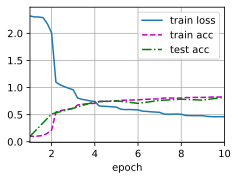

In [10]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())